In [101]:
import pandas as pd
import numpy as np
import math
import keras
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('df5_2102.csv')

sensor_id = [329, 332, 335]
freezer_id = [344, 362, 368]

In [102]:
import random
for col in ['operation_'+ str(_id) for _id in freezer_id]:
    df[col+'_random'] = [random.randint(0,1) for r in range(len(df))]

In [103]:
cols = ['gw_time'] + ['temperature_329'] + ['temperature_329_prime'] + ['dT_329'] + ['operation_'+str(_id) for _id in freezer_id] + ['operation_'+str(_id) + '_random'for _id in freezer_id]
df = df[cols]

In [104]:
df['dT_329'] = np.round(df['dT_329'], 2)

In [105]:
df['ddT_329'] = df['dT_329']-df['dT_329'].shift(1)

In [106]:
df = df.dropna()

In [91]:
df

,gw_time,temperature_329,temperature_329_prime,dT_329,operation_344,operation_362,operation_368,operation_344_random,operation_362_random,operation_368_random,ddT_329
9,2021-02-01 00:04:36,-20.28,-20.29,0.01,0.0,1.0,1.0,1,0,0,0.00
10,2021-02-01 00:05:06,-20.29,-20.28,-0.01,0.0,1.0,1.0,1,1,0,-0.02
11,2021-02-01 00:05:36,-20.29,-20.29,0.00,0.0,1.0,1.0,0,1,1,0.01
12,2021-02-01 00:06:06,-20.29,-20.29,0.00,0.0,1.0,1.0,1,1,1,0.00
13,2021-02-01 00:06:36,-20.30,-20.29,-0.01,0.0,1.0,1.0,1,1,1,-0.01
...,...,...,...,...,...,...,...,...,...,...,...
80124,2021-02-28 23:57:33,-18.94,-18.94,0.00,1.0,1.0,1.0,1,0,0,-0.01
80125,2021-02-28 23:58:03,-18.95,-18.94,-0.01,1.0,1.0,1.0,1,1,0,-0.01
80126,2021-02-28 23:58:33,-18.93,-18.95,0.02,1.0,1.0,1.0,0,0,1,0.03
80127,2021-02-28 23:59:03,-18.95,-18.93,-0.02,1.0,1.0,1.0,1,0,1,-0.04


In [107]:
df['gw_time'] = pd.to_datetime(df['gw_time'])

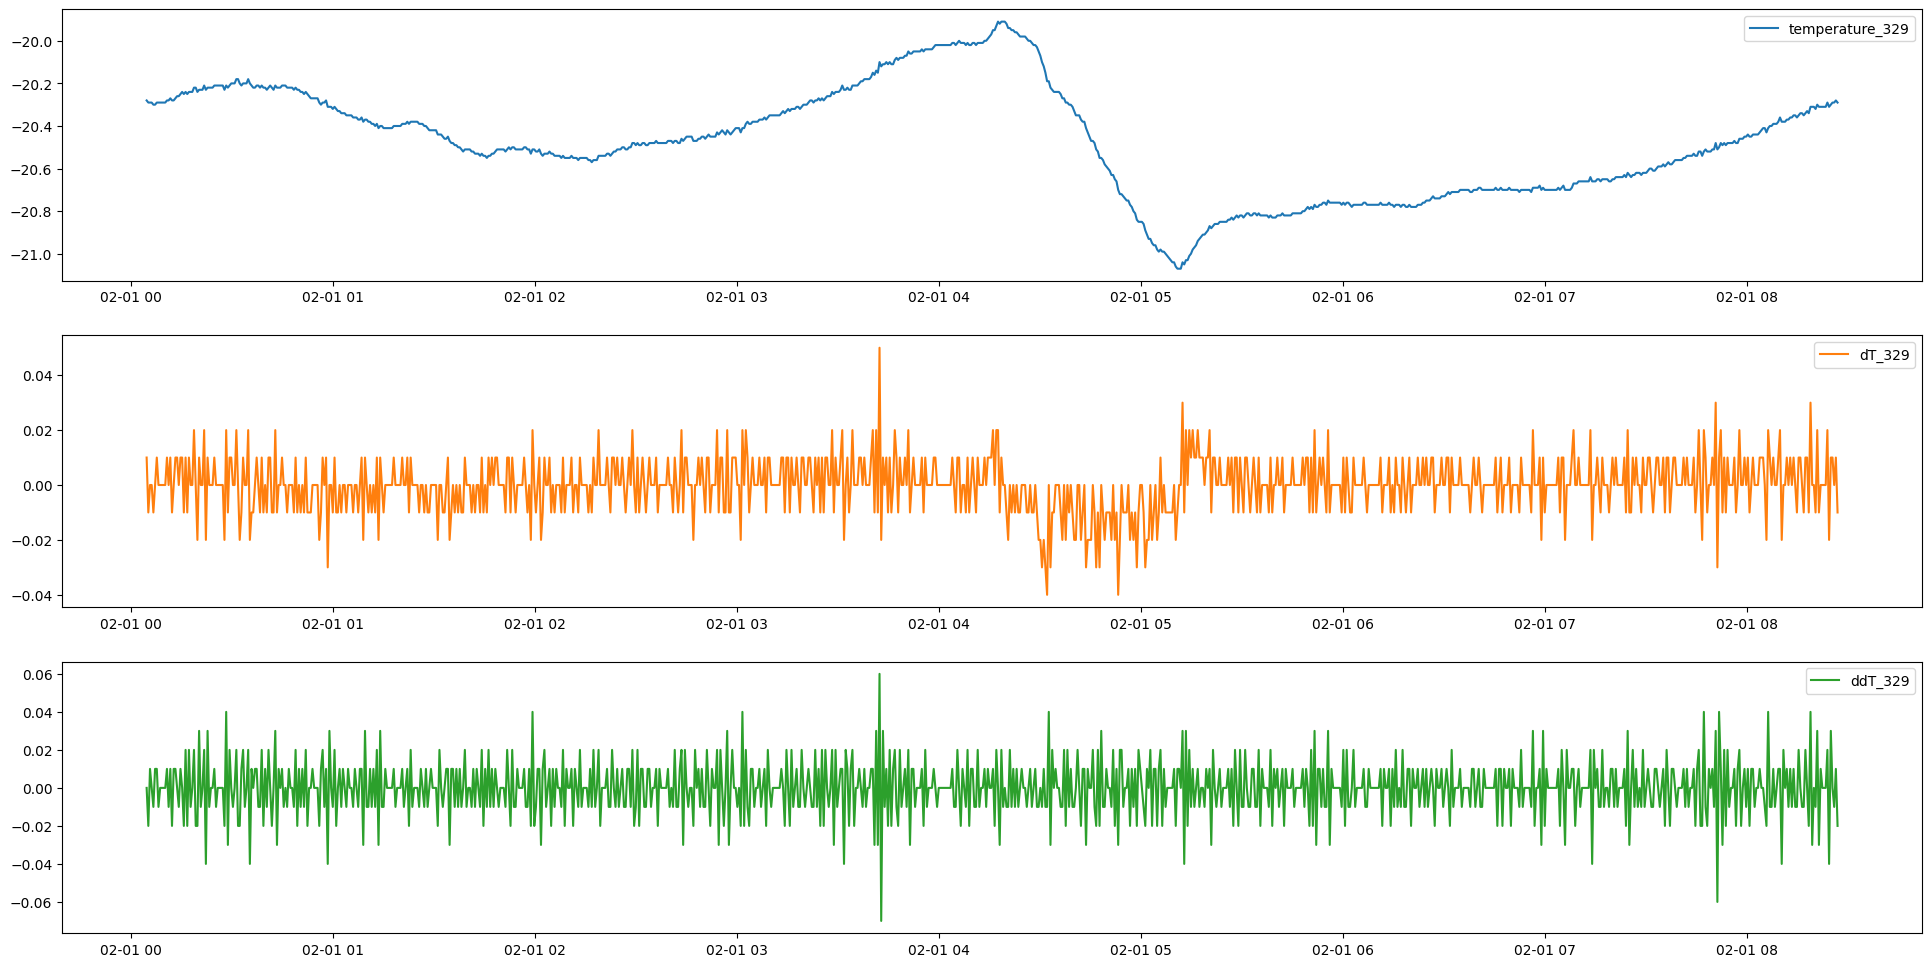

In [108]:
test_figure = df[:1000]
plt.figure(figsize = (24,12))
count = 1
colors = ['tab:blue','tab:orange','tab:green']
for elem in ['temperature_329', 'dT_329','ddT_329']:
    plt.subplot(3,1,count)
    plt.plot(test_figure['gw_time'], test_figure[elem], label =elem, color = colors[count-1])
    count += 1
    plt.legend()
plt.show()

In [109]:
df

,gw_time,temperature_329,temperature_329_prime,dT_329,operation_344,operation_362,operation_368,operation_344_random,operation_362_random,operation_368_random,ddT_329
9,2021-02-01 00:04:36,-20.28,-20.29,0.01,0.0,1.0,1.0,1,0,0,0.00
10,2021-02-01 00:05:06,-20.29,-20.28,-0.01,0.0,1.0,1.0,1,1,1,-0.02
11,2021-02-01 00:05:36,-20.29,-20.29,0.00,0.0,1.0,1.0,1,0,1,0.01
12,2021-02-01 00:06:06,-20.29,-20.29,0.00,0.0,1.0,1.0,0,1,0,0.00
13,2021-02-01 00:06:36,-20.30,-20.29,-0.01,0.0,1.0,1.0,1,0,0,-0.01
...,...,...,...,...,...,...,...,...,...,...,...
80124,2021-02-28 23:57:33,-18.94,-18.94,0.00,1.0,1.0,1.0,0,0,0,-0.01
80125,2021-02-28 23:58:03,-18.95,-18.94,-0.01,1.0,1.0,1.0,0,1,0,-0.01
80126,2021-02-28 23:58:33,-18.93,-18.95,0.02,1.0,1.0,1.0,0,0,0,0.03
80127,2021-02-28 23:59:03,-18.95,-18.93,-0.02,1.0,1.0,1.0,1,0,0,-0.04


In [110]:
TEST_SIZE = 8000
train = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]
train.shape, test.shape


((72120, 11), (8000, 11))

In [111]:
from sklearn.preprocessing import MinMaxScaler

scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
for col in cols[1:]:
    train[col] = scaler_train.fit_transform(train[col].values.reshape(-1,1))
    test[col] = scaler_train.transform(test[col].values.reshape(-1,1))

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_5196\3317229046.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scaler_train.fit_transform(train[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_5196\3317229046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = scaler_train.transform(test[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_5196\3317229046.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [120]:
feature_cols1 = ['operation_'+str(_id) for _id in freezer_id] + ['ddT_329']
feature_cols2 = ['operation_'+str(_id)+'_random' for _id in freezer_id] + ['ddT_329']
label_cols =  ['dT_329']

In [121]:
train_feature = train[feature_cols1]
train_feature2 = train[feature_cols2]
train_label = train[label_cols]

# train, validation set 생성
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_feature,train_label,test_size=0.1, shuffle= False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_feature2,train_label,test_size=0.1, shuffle= False)
X_test2.columns = X_test.columns
X_train.shape, X_test.shape
# ((57676, 20, 21), (14419, 20, 21))

((64908, 4), (7212, 4))

In [114]:
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [115]:
print(len(X_train), len(X_test))
xgb_model.fit(X_train,y_train)

64908 7212


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [122]:
predictions = xgb_model.predict(X_test)
import random
for col in ['operation_'+ str(_id) for _id in freezer_id]:
    df[col] = [random.randint(0,1) for r in range(len(df))]
predictions2 = xgb_model.predict(X_test2)
predictions

array([0.46842498, 0.44574046, 0.34698522, ..., 0.44574046, 0.44574046,
       0.39863098], dtype=float32)

In [138]:
r_sq = xgb_model.score(X_train, y_train)
print(r_sq)
print(explained_variance_score(predictions,y_test))
print(explained_variance_score(predictions2,y_test))

0.4468820741397659
-0.36180462926924095
-0.32014013078346104


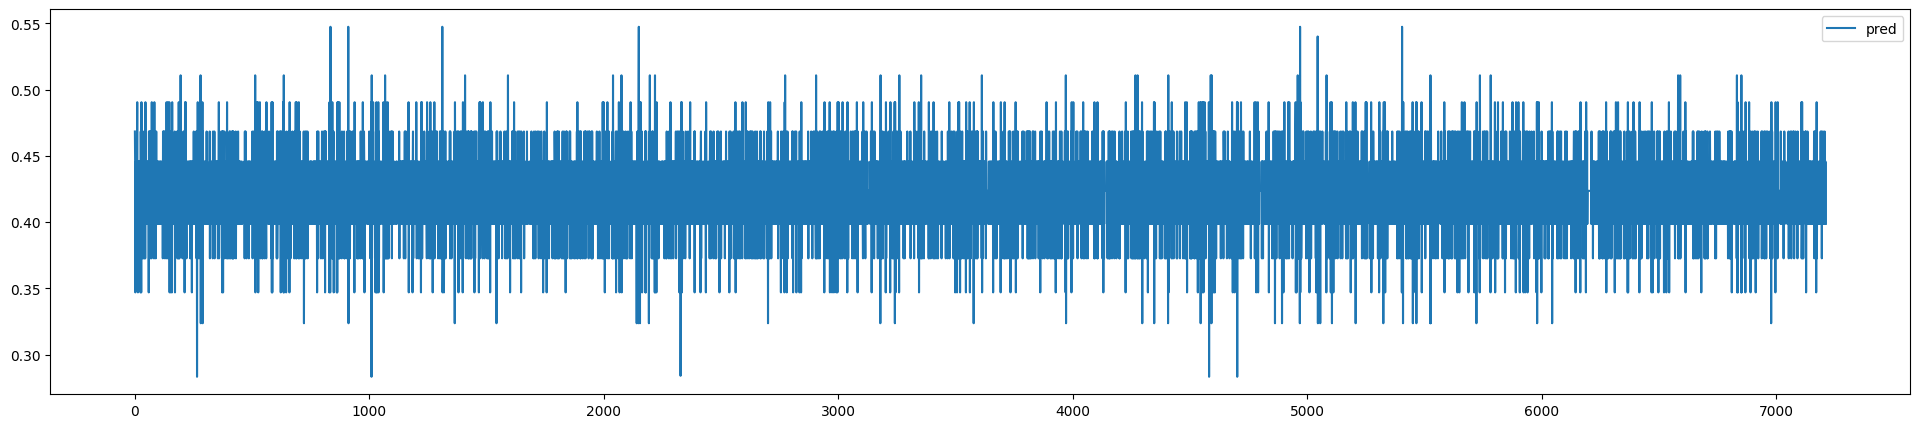

In [124]:
plt.figure(figsize=(24,5))
# plt.plot(y_test.reset_index(drop = True), label = 'actual')
plt.plot(predictions, label = 'pred')
plt.legend()
plt.show()

In [125]:
np.unique(predictions)

array([0.2832805 , 0.28401816, 0.3236856 , 0.34698522, 0.37268323,
       0.39863098, 0.42361718, 0.44574046, 0.46842498, 0.4905285 ,
       0.5108217 , 0.54014075, 0.54746586], dtype=float32)

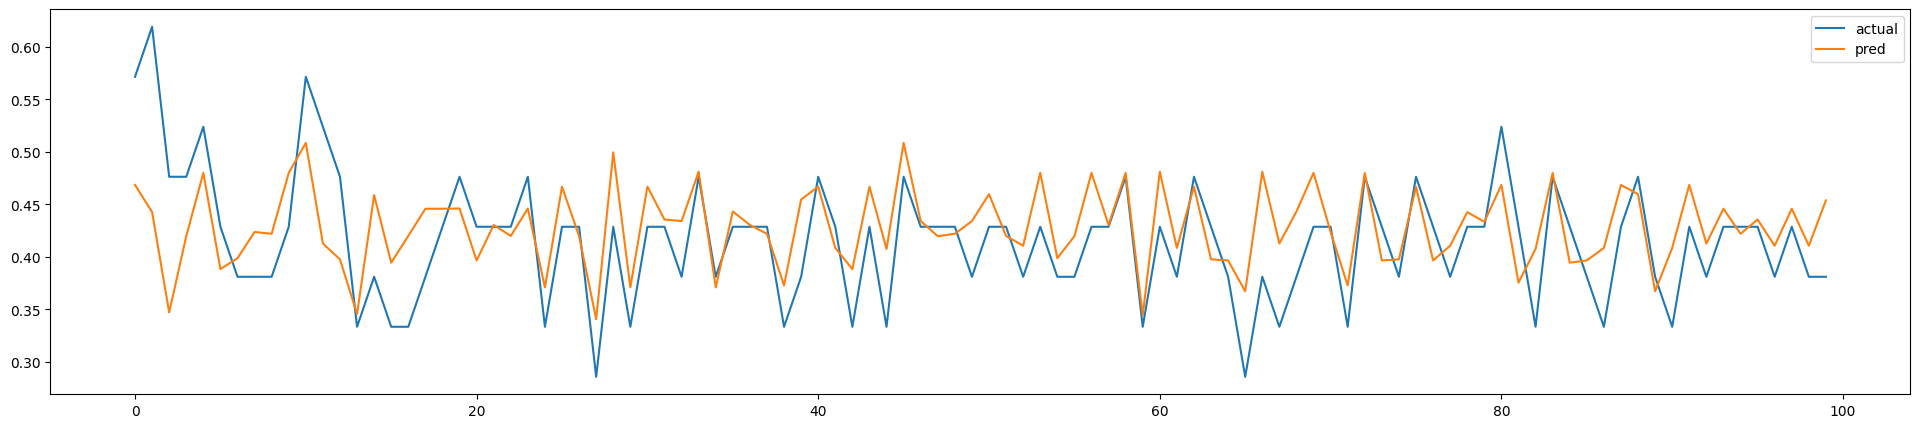

In [127]:
plt.figure(figsize=(24,5))
plt.plot(y_test.reset_index(drop = True)[:100], label = 'actual')
plt.plot(predictions2[:100], label = 'pred')
plt.legend()
plt.show()

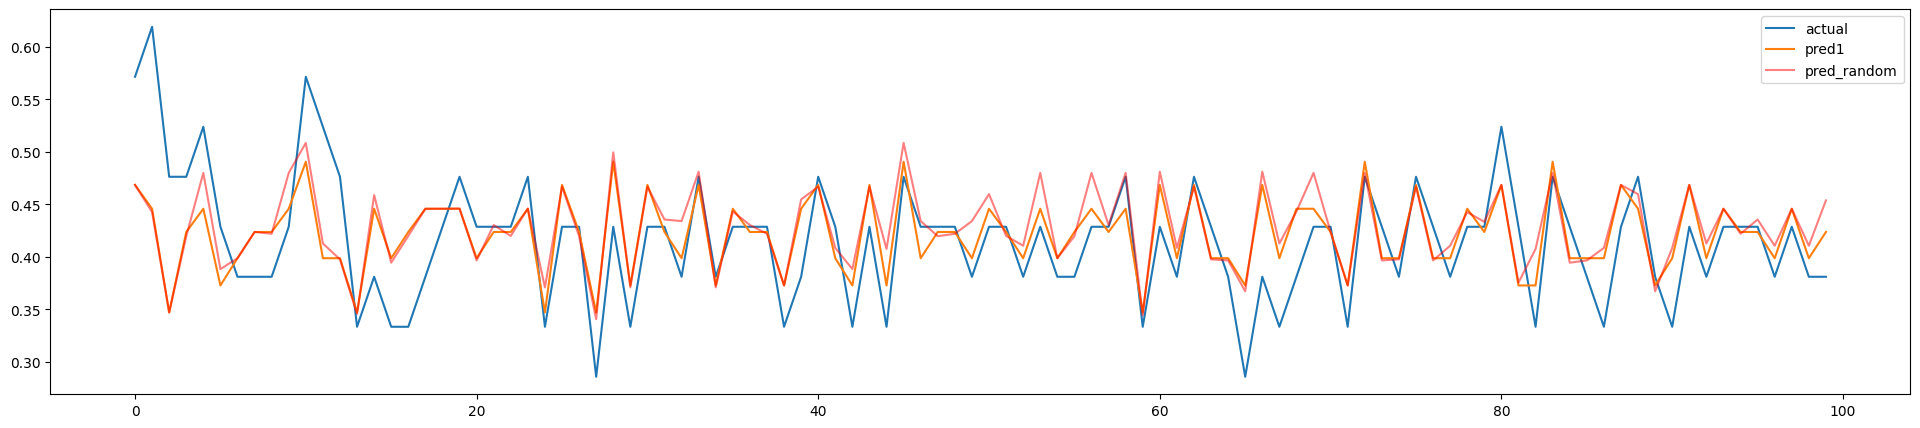

In [137]:
plt.figure(figsize=(24,5))
plt.plot(y_test.reset_index(drop = True)[:100], label = 'actual')
plt.plot(predictions[:100], label = 'pred1')
plt.plot(predictions2[:100], label = 'pred_random',color = 'r', alpha = 0.5)
plt.legend()
plt.show()